In [1]:
from odes.models import SIR
from odes.integrator import integrator
from odes.neural_ODE import nUIV_NODE
import torch
# import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [11]:
# helper function to step the SIR model forward and generate a data set
def generate_SIR_data(model, num_steps):
    t = torch.zeros(num_steps)
    y = torch.zeros(3, num_steps)
    y[:, 0] = torch.from_numpy(model.x)
    t[0] = torch.tensor(0.0)
    for i in range(num_steps):
        y[:, i] = torch.from_numpy(model.step())
        t[i] = torch.tensor(model.t)
    return y, t

In [12]:
# setting up SIR reference data
num_hosts = 50
num_steps = 400*10
dt = 0.01 #0.05
torch.manual_seed(666)

beta = 0.35
gamma = 0.035

time_scale = 1 #25.0  # can make time "move faster" by scaling these constants beyond [0, 1]
beta = time_scale*beta  # infection rate
gamma = time_scale*gamma  # recovery rate
SIR_ODE = SIR(1, beta, gamma)
SIR_x0 = np.array([0.8, 0.2, 0.0])


# generate data
SIR_stepper = integrator(SIR_ODE, SIR_x0, dt)
SIR_train_data, time_train_data = generate_SIR_data(SIR_stepper, num_steps)

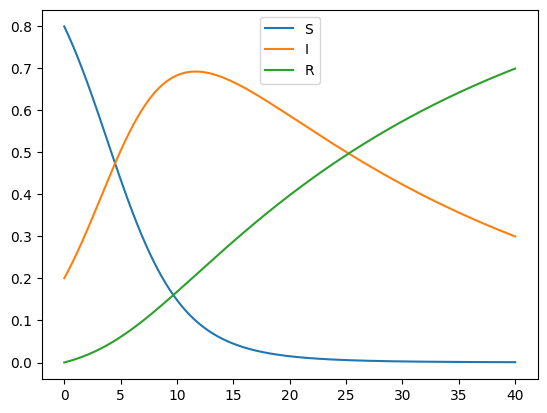

In [13]:
plt.plot(time_train_data, SIR_train_data.T)
plt.legend(["S","I","R"])
plt.show()

In [14]:
regularize = True
reg_weight = 0.01

beta = 4.71
delta = 1.07
p = 3.07
c = 2.3

param_train = (torch.tensor([beta, delta, p, c], dtype=torch.float32)*torch.ones(num_hosts, 4)).T.flatten()

In [15]:
num_epochs = 200

method = 'euler'
step_size = 2*dt
device = 'cpu'  # torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = nUIV_NODE(num_hosts, method=method, step_size=step_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=0.0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)

loss_function = lambda y, yhat: torch.norm(y-yhat, p=2)  # nn.L1Loss()

y_train = torch.cat((SIR_train_data[0,:], SIR_train_data[1,:], SIR_train_data[2,:]))

if regularize:
    y_train = torch.cat([y_train, reg_weight*param_train])

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [16]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    SIR_est = model.simulate(time_train_data.to(device)).to(device)
    y_est = torch.cat((SIR_est[0,:], SIR_est[1,:], SIR_est[2,:]))

    if regularize:
        param_est = torch.cat([model.nUIV_dynamics.betas, model.nUIV_dynamics.deltas, model.nUIV_dynamics.ps, model.nUIV_dynamics.cs])
        y_est = torch.cat([y_est, reg_weight*param_est])

    loss = loss_function(y_est, y_train.to(device))
    loss_val = loss.item()
    loss.backward()
    optimizer.step()
    scheduler.step(loss_val)

    print(f'Epoch {epoch}, loss value: {loss_val}.')
    if torch.isnan(loss):
        raise ValueError('Found NaN loss, exiting...')

Epoch 0, loss value: 86.90642547607422.
Epoch 1, loss value: 44.436553955078125.
Epoch 2, loss value: 42.51179504394531.
Epoch 3, loss value: 41.3273811340332.
Epoch 4, loss value: 38.00946807861328.
Epoch 5, loss value: 34.494422912597656.
Epoch 6, loss value: 30.806076049804688.
Epoch 7, loss value: 26.269033432006836.
Epoch 8, loss value: 22.464994430541992.
Epoch 9, loss value: 23.212404251098633.
Epoch 10, loss value: 19.782594680786133.
Epoch 11, loss value: 18.979093551635742.
Epoch 12, loss value: 17.43773651123047.
Epoch 13, loss value: 16.464866638183594.
Epoch 14, loss value: 16.7655029296875.
Epoch 15, loss value: 16.012460708618164.
Epoch 16, loss value: 16.598737716674805.
Epoch 17, loss value: 15.431215286254883.
Epoch 18, loss value: 15.651077270507812.
Epoch 19, loss value: 14.68542766571045.
Epoch 20, loss value: 14.28868293762207.
Epoch 21, loss value: 13.845827102661133.
Epoch 22, loss value: 13.061477661132812.
Epoch 23, loss value: 13.087798118591309.
Epoch 24, lo

## Results

In [31]:
nUIV_params = model.get_params()
SIR_params = {'beta': beta,
              'gamma': gamma,
              'x0': SIR_x0,
              'num_hosts': num_hosts}

sim_params = {'SIR': SIR_params,
              'nUIV': nUIV_params}

# print(nUIV_params)

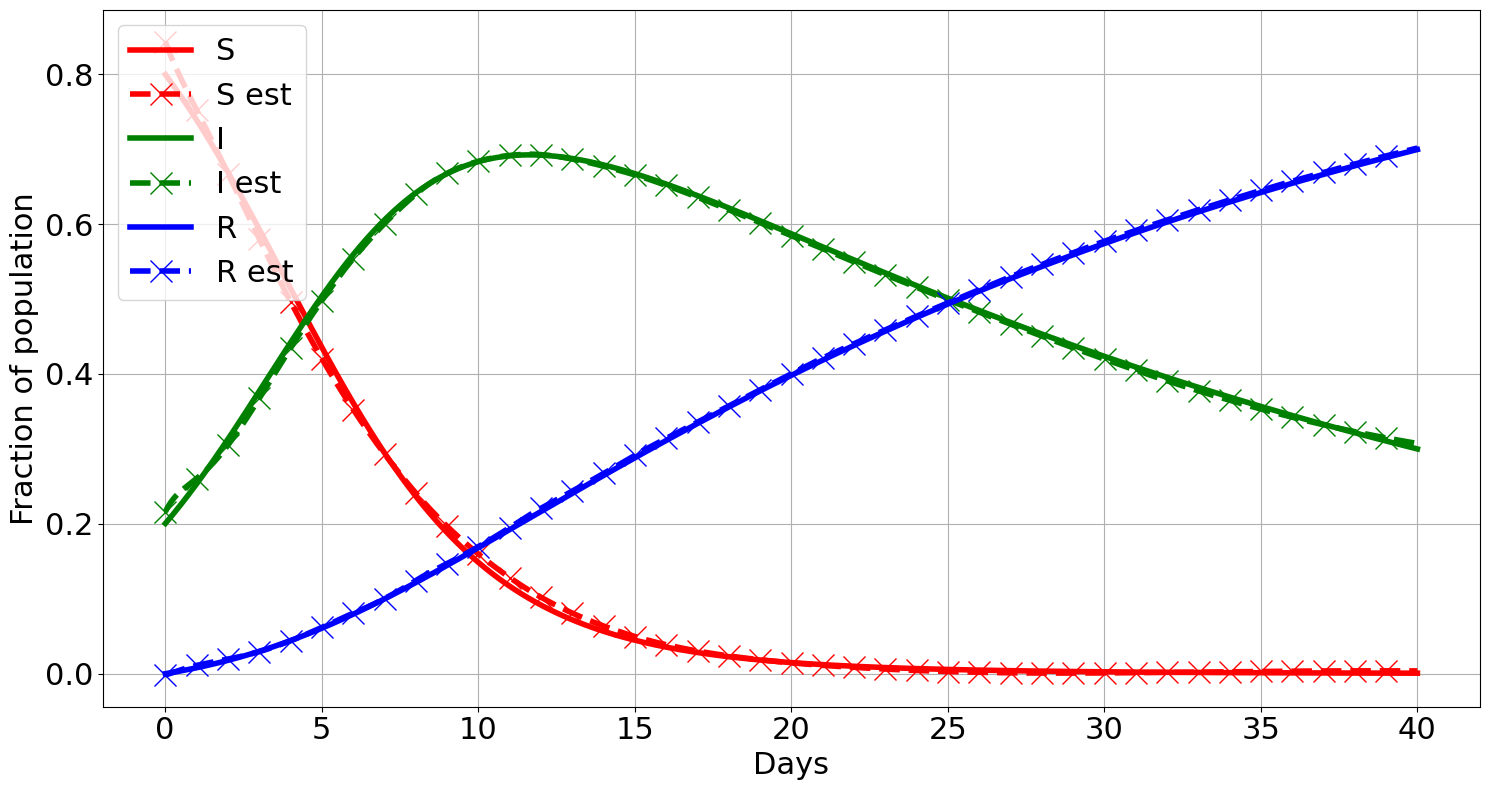

In [30]:
with torch.no_grad():
    SIR_train_data_est = model.simulate(time_train_data.to(device)).detach().cpu().numpy()

f, ax1 = plt.subplots(figsize=(15, 8))
names = ['S', 'I', 'R']
colors = ['red', 'green', 'blue']

for i, name in enumerate(names):
    ax1.plot(time_train_data*time_scale, SIR_train_data[i, :], lw=4, color=colors[i], label=name)
    ax1.plot(time_train_data*time_scale, SIR_train_data_est[i, :], lw=4, color=colors[i], label=name+' est', linestyle='dashed', marker='x', markersize=16, markevery=100)

fontsize = 22

ax1.grid()
# ax2.grid()
ax1.legend(fontsize=fontsize)
ax1.set_xlabel("Days", fontsize=fontsize)
ax1.set_ylabel("Fraction of population", fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
# ax2.legend()
f.tight_layout()

path = './tmp/'
if not os.path.exists(path):
    os.mkdir(path)
filename = os.path.join(path, 'last_run_pytorch.png')
f.savefig(filename)
plt.show()

## Parameter Plots

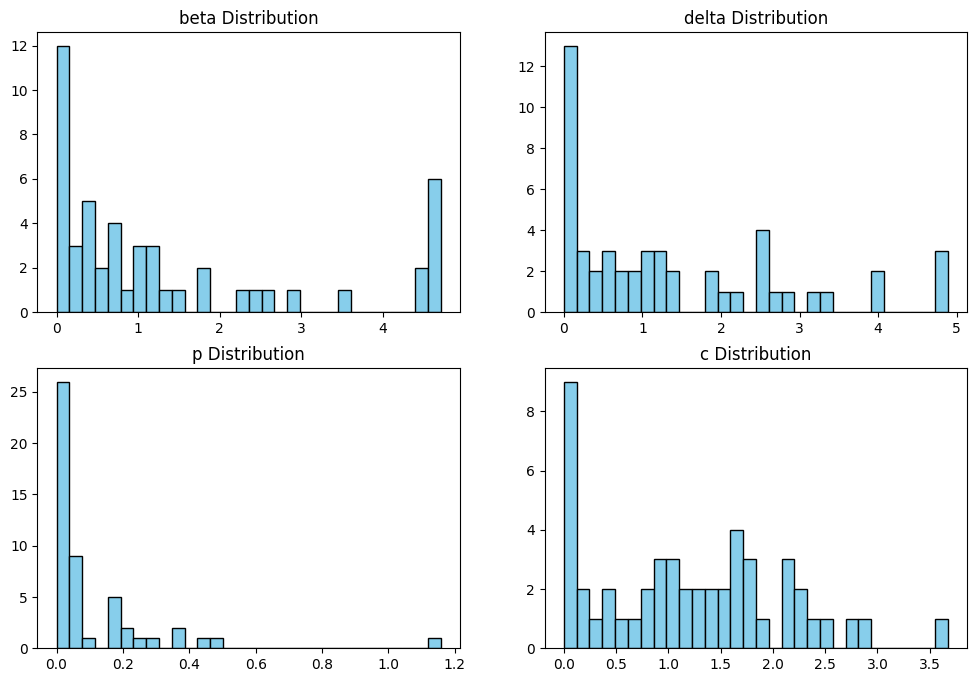

In [19]:
params = ['beta', 'delta', 'p', 'c']

plt.figure(figsize=(12,8))
for i,param in enumerate(params):
    plt.subplot(2,2,i+1)
    plt.hist(nUIV_params[param], bins=30, color='skyblue', edgecolor='black')
    plt.title(param+' Distribution')
    # plt.xlabel('Value')
    # plt.ylabel('Frequency')
    # plt.grid(True)
plt.show()

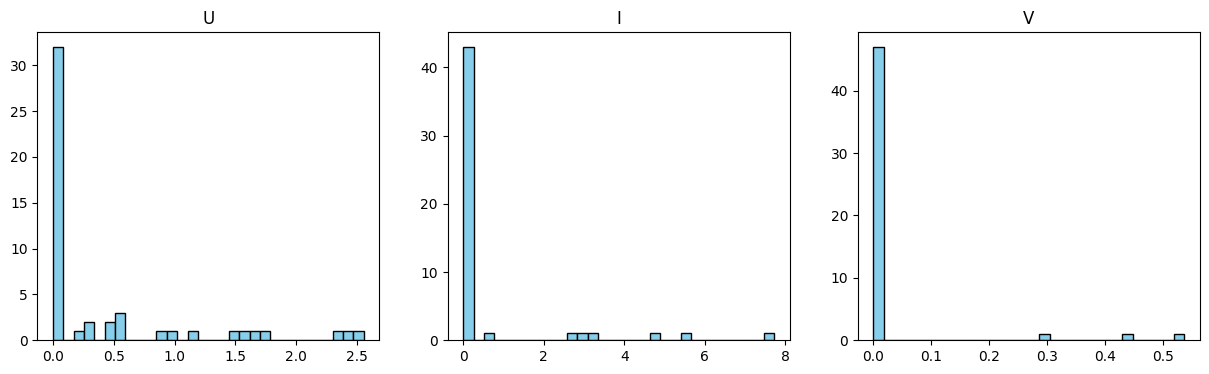

In [20]:
states= ['U', 'I', 'V']
plt.figure(figsize=(15,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist(nUIV_params['x0'][i::3], bins=30, color='skyblue', edgecolor='black')
    plt.title(states[i])

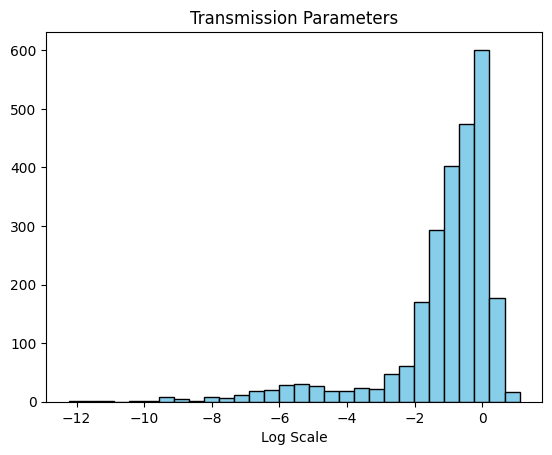

In [21]:
ts = model.nUIV_dynamics.ts.detach().flatten().numpy()
plt.hist(np.log10(ts), bins=30, color='skyblue', edgecolor='black')
plt.title("Transmission Parameters")
plt.xlabel("Log Scale")
plt.show()

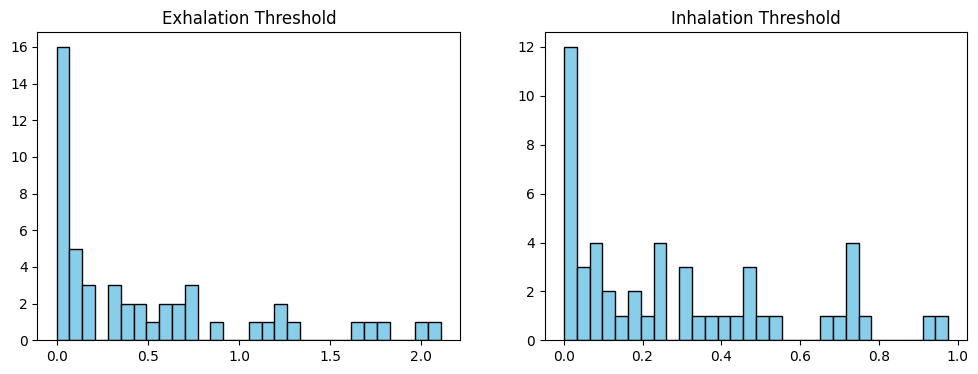

In [22]:
plt.figure(figsize=(12,4))

ex_thresh = model.nUIV_dynamics.ex_thresh.detach().flatten().numpy()
plt.subplot(1,2,1)
plt.title("Exhalation Threshold")
plt.hist(ex_thresh, bins=30, color='skyblue', edgecolor='black')

in_thresh = model.nUIV_dynamics.in_thresh.detach().flatten().numpy()
plt.subplot(1,2,2)
plt.title("Inhalation Threshold")
plt.hist(in_thresh, bins=30, color='skyblue', edgecolor='black')

plt.show()

In [23]:
model.nUIV_to_SIR.W.weight

Parameter containing:
tensor([[-0.2609,  1.6974, -0.1969],
        [ 2.2779, -1.3207,  0.5360],
        [-0.7234,  0.4725,  1.2507]], requires_grad=True)

In [28]:
print(model.nUIV_to_SIR.W.bias)

None


## Fixing Map

In [ ]:
for param in model.nUIV_to_SIR.W.parameters():
    param.requires_grad = False

model.nUIV_to_SIR.W.weight

Parameter containing:
tensor([[ 1.0904,  0.7125,  0.3481],
        [ 0.4558, -0.0067, -0.6747],
        [-0.1466,  0.4029,  0.9309]])

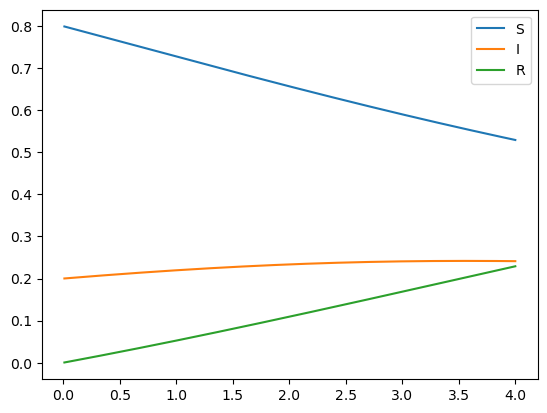

In [ ]:
beta = time_scale*0.9  # infection rate
gamma = time_scale*0.01  # recovery rate
SIR_ODE = SIR(num_hosts, beta, gamma)
SIR_x0 = np.array([0.8, 0.2, 0])


# generate data
SIR_stepper = integrator(SIR_ODE, SIR_x0, dt)
SIR_train_data, time_train_data = generate_SIR_data(SIR_stepper, num_steps)

y_train = torch.cat((SIR_train_data[0,:], SIR_train_data[1,:], SIR_train_data[2,:]))
if regularize:
    y_train = torch.cat([y_train, reg_weight*param_train])

plt.plot(time_train_data, SIR_train_data.T)
plt.legend(["S","I","R"])
plt.show()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=0.0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)

for epoch in range(num_epochs):
    optimizer.zero_grad()

    SIR_est = model.simulate(time_train_data.to(device)).to(device)
    y_est = torch.cat((SIR_est[0,:], SIR_est[1,:], SIR_est[2,:]))

    if regularize:
        param_est = torch.cat([model.nUIV_dynamics.betas, model.nUIV_dynamics.deltas, model.nUIV_dynamics.ps, model.nUIV_dynamics.cs])
        y_est = torch.cat([y_est, reg_weight*param_est])

    loss = loss_function(y_est, y_train.to(device))
    loss_val = loss.item()
    loss.backward()
    optimizer.step()
    scheduler.step(loss_val)

    print(f'Epoch {epoch}, loss value: {loss_val}.')
    if torch.isnan(loss):
        raise ValueError('Found NaN loss, exiting...')

Epoch 0, loss value: 4.27988338470459.
Epoch 1, loss value: 2.428673505783081.
Epoch 2, loss value: 2.8527820110321045.
Epoch 3, loss value: 2.666680335998535.
Epoch 4, loss value: 2.1977031230926514.
Epoch 5, loss value: 2.4594504833221436.
Epoch 6, loss value: 2.5234062671661377.
Epoch 7, loss value: 2.2411038875579834.
Epoch 8, loss value: 2.2119600772857666.
Epoch 9, loss value: 2.317567825317383.
Epoch 10, loss value: 2.271759033203125.
Epoch 11, loss value: 2.120651960372925.
Epoch 12, loss value: 2.1259899139404297.
Epoch 13, loss value: 2.1940865516662598.
Epoch 14, loss value: 2.142240524291992.
Epoch 15, loss value: 2.046771287918091.
Epoch 16, loss value: 2.084240674972534.
Epoch 17, loss value: 2.1041297912597656.
Epoch 18, loss value: 2.0521163940429688.
Epoch 19, loss value: 2.0087082386016846.
Epoch 20, loss value: 2.0479536056518555.
Epoch 21, loss value: 2.04593563079834.
Epoch 22, loss value: 1.9993106126785278.
Epoch 23, loss value: 1.9857274293899536.
Epoch 24, loss

KeyboardInterrupt: 

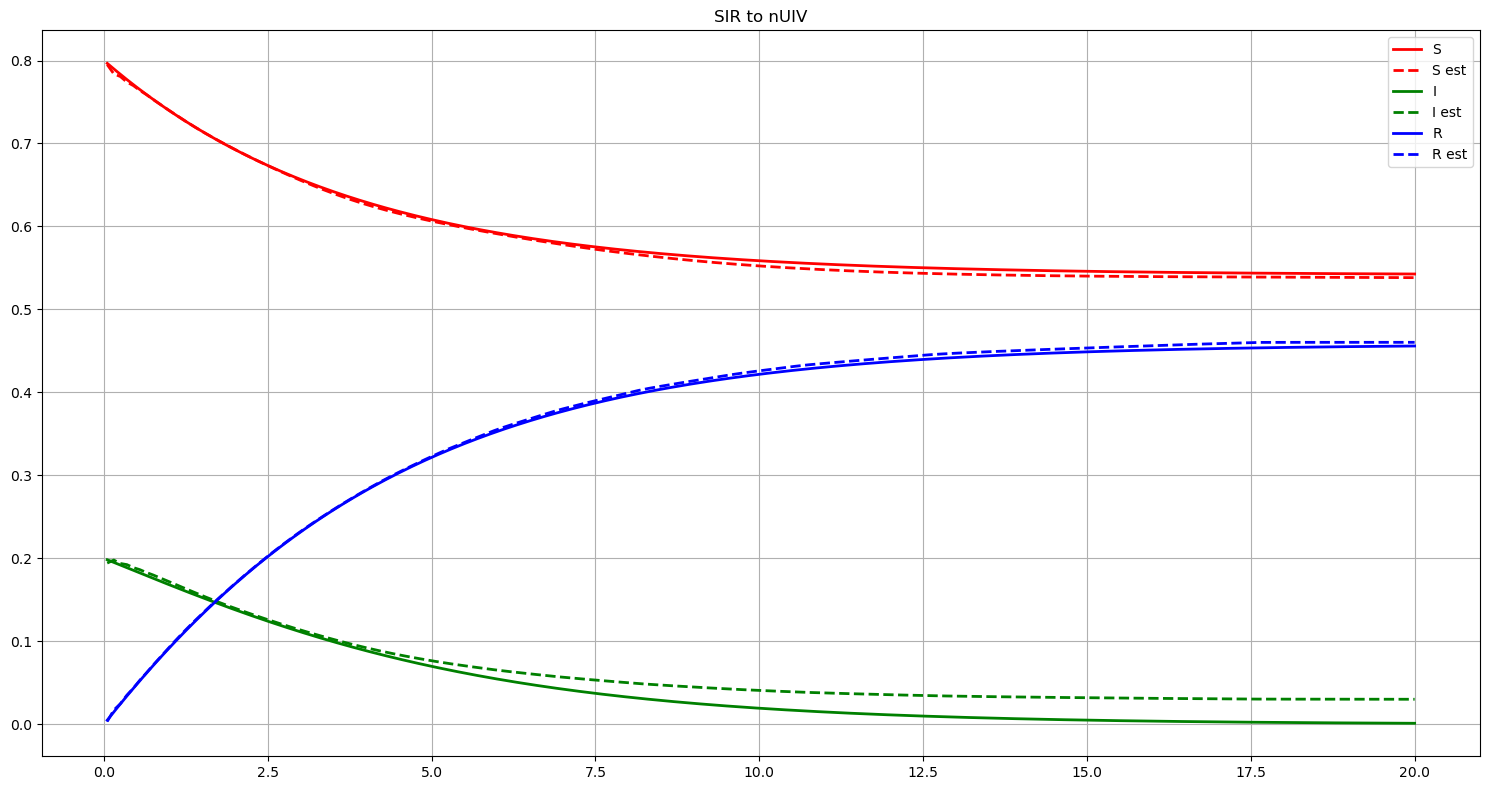

In [ ]:
with torch.no_grad():
    SIR_train_data_est = model.simulate(time_train_data.to(device)).detach().cpu().numpy()

f, ax1 = plt.subplots(figsize=(15, 8))
names = ['S', 'I', 'R']
colors = ['red', 'green', 'blue']

for i, name in enumerate(names):
    ax1.plot(time_train_data, SIR_train_data[i, :], lw=2, color=colors[i], label=name)
    ax1.plot(time_train_data, SIR_train_data_est[i, :], lw=2, color=colors[i], label=name+' est', linestyle='dashed')

ax1.set_title('SIR to nUIV')
ax1.grid()
ax1.legend()
f.tight_layout()

plt.show()

## Fixing Map and Parameters

In [ ]:
for param in model.nUIV_to_SIR.W.parameters():
    param.requires_grad = False

for param in model.nUIV_dynamics.parameters():
    param.requires_grad = False

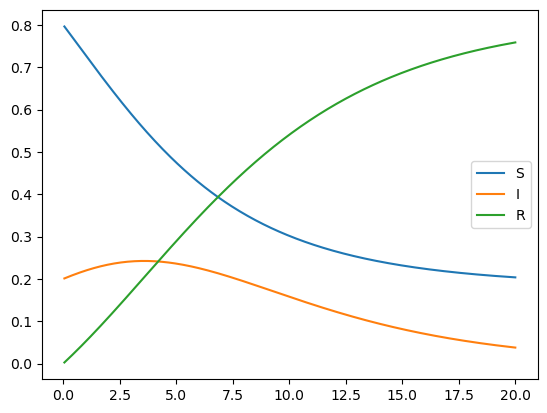

In [ ]:
beta = time_scale*0.9  # infection rate
gamma = time_scale*0.01  # recovery rate
SIR_ODE = SIR(num_hosts, beta, gamma)
SIR_x0 = np.array([0.8, 0.2, 0])


# generate data
SIR_stepper = integrator(SIR_ODE, SIR_x0, dt)
SIR_train_data, time_train_data = generate_SIR_data(SIR_stepper, num_steps)

y_train = torch.cat((SIR_train_data[0,:], SIR_train_data[1,:], SIR_train_data[2,:]))
if regularize:
    y_train = torch.cat([y_train, reg_weight*param_train])

plt.plot(time_train_data, SIR_train_data.T)
plt.legend(["S","I","R"])
plt.show()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=0.0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)

for epoch in range(num_epochs):
    optimizer.zero_grad()

    SIR_est = model.simulate(time_train_data.to(device)).to(device)
    y_est = torch.cat((SIR_est[0,:], SIR_est[1,:], SIR_est[2,:]))

    if regularize:
        param_est = torch.cat([model.nUIV_dynamics.betas, model.nUIV_dynamics.deltas, model.nUIV_dynamics.ps, model.nUIV_dynamics.cs])
        y_est = torch.cat([y_est, reg_weight*param_est])

    loss = loss_function(y_est, y_train.to(device))
    loss_val = loss.item()
    loss.backward()
    optimizer.step()
    scheduler.step(loss_val)

    print(f'Epoch {epoch}, loss value: {loss_val}.')
    if torch.isnan(loss):
        raise ValueError('Found NaN loss, exiting...')

Epoch 0, loss value: 1.3741705417633057.
Epoch 1, loss value: 2.016446113586426.
Epoch 2, loss value: 1.4534237384796143.
Epoch 3, loss value: 0.6714874505996704.
Epoch 4, loss value: 1.041634440422058.
Epoch 5, loss value: 0.8112066388130188.
Epoch 6, loss value: 0.49507004022598267.
Epoch 7, loss value: 0.8013504147529602.
Epoch 8, loss value: 0.5978142023086548.
Epoch 9, loss value: 0.46599531173706055.
Epoch 10, loss value: 0.6315231323242188.
Epoch 11, loss value: 0.4651899039745331.
Epoch 12, loss value: 0.45630985498428345.
Epoch 13, loss value: 0.5357856750488281.
Epoch 14, loss value: 0.3818594515323639.
Epoch 15, loss value: 0.4485129117965698.
Epoch 16, loss value: 0.4818665683269501.
Epoch 17, loss value: 0.35445669293403625.
Epoch 18, loss value: 0.42836710810661316.
Epoch 19, loss value: 0.4191502034664154.
Epoch 20, loss value: 0.3284728527069092.
Epoch 21, loss value: 0.4091232419013977.
Epoch 22, loss value: 0.35530105233192444.
Epoch 23, loss value: 0.3392744362354278

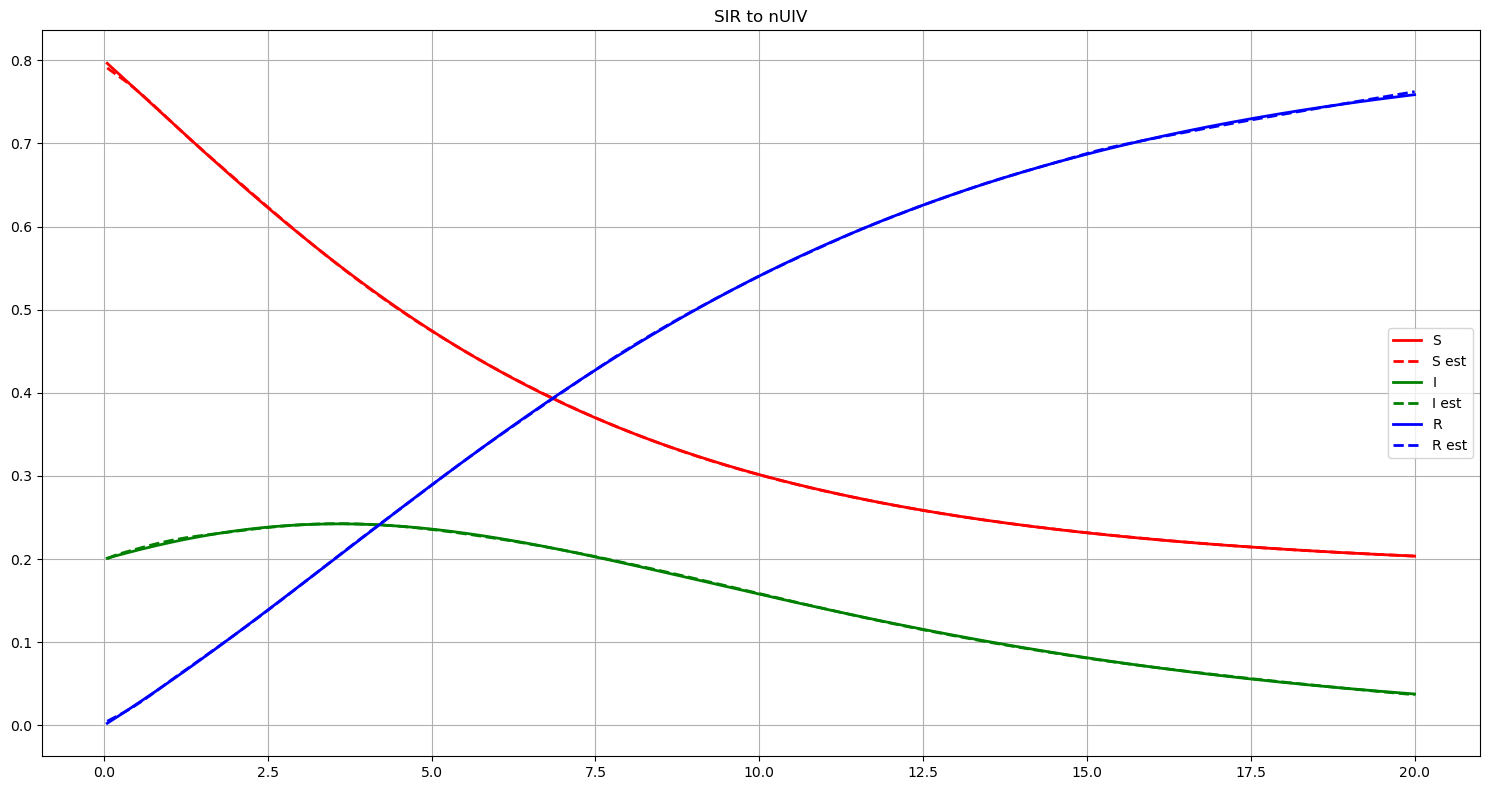

In [ ]:
with torch.no_grad():
    SIR_train_data_est = model.simulate(time_train_data.to(device)).detach().cpu().numpy()

f, ax1 = plt.subplots(figsize=(15, 8))
names = ['S', 'I', 'R']
colors = ['red', 'green', 'blue']

for i, name in enumerate(names):
    ax1.plot(time_train_data, SIR_train_data[i, :], lw=2, color=colors[i], label=name)
    ax1.plot(time_train_data, SIR_train_data_est[i, :], lw=2, color=colors[i], label=name+' est', linestyle='dashed')

ax1.set_title('SIR to nUIV')
ax1.grid()
ax1.legend()
f.tight_layout()

plt.show()